### Постановка задачи<a class="anchor" id="task"></a>

Требуется на основании демографических данных о клиентах банка, истории их платежей и состоянии счета, предсказать невыполнение их обязательств по кредитной карте в следующем месяце.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import copy
import pandas as pd
import pickle
import random
import re
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline



import warnings
warnings.simplefilter('ignore')

**Полезные функции**

In [2]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 19):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [3]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**RandomForestRegression** - для предсказания пропущенных значений

In [7]:
def rforest_prediction(input_train, input_need_predict, target):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.preprocessing import StandardScaler
    #Создаю копии полученных данных
    train = copy.deepcopy(input_train)
    #valid = copy.deepcopy(input_valid)
    need_predict = copy.deepcopy(input_need_predict)
       
    
    #Создаю регрессионную модель
    model = RandomForestRegressor(n_estimators=500, max_depth=20, max_features=input_train.shape[1]-1, n_jobs=-1, random_state=42, verbose=1)
    train_target = train.pop(target) #Отделяю целевое значение
    model.fit(train, train_target) #Обучаю модель
    pred_train = model.predict(train)
    print(f"r2 на учебной выборке: {r2_score(train_target, pred_train)}")
   
    
    if (type(need_predict) != bool):
        print(f"Прогнозирую {target}")
        need_predict.pop(target)
        print(need_predict.shape)
        return model.predict(need_predict)

**Пути файлов**

In [8]:
# input
TRAIN_PATH = './course_project/course_project_train.csv'
TEST_PATH = './course_project/course_project_test.csv'

# output
PREPARED_TRAIN_PATH = './course_project/course_project_data_prep.csv'
#TRAIN_PART_PATH = './course_project/course_project_train_b.csv'
PREDICTION_PATH = './course_project/EMikhachev_prediction.csv'

SCALER_FILE_PATH = './scaler.pkl'
MODEL_FILE_PATH = './model.pkl'

### Обзор и анализ данных <a class="anchor" id="load_data"></a>

In [9]:
df = pd.read_csv(TRAIN_PATH)
#df_base = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
df.shape

(7500, 17)

In [11]:
#df.dtypes()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [13]:
'''
for colname in [ 'Purpose', 'Term']:
    df[colname] = df[colname].astype(str)'''

"\nfor colname in [ 'Purpose', 'Term']:\n    df[colname] = df[colname].astype(str)"

In [14]:
df.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

**Обзор целевой переменной**

In [15]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Обзор количественных признаков**

In [16]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных признаков**

In [17]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [18]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

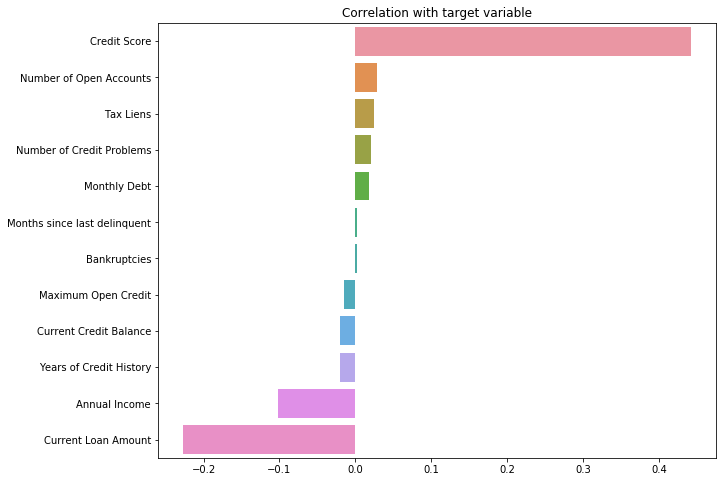

In [19]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Home Ownership**

In [20]:
print(df['Home Ownership'].value_counts())

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64


Этот параметр должен сильно влиять на платежеспособность, так разобью его на отдельные колонки

**Annual Income**

Немало пропущенных, плюс третье место важности для целевой переменной, поэтому для точного заполнения пропущенных анализ и обработка сделаю не самыми простыми.

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64


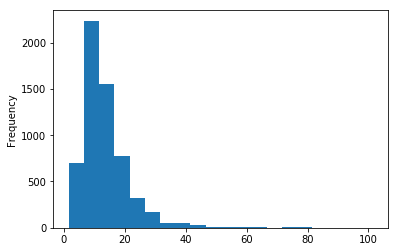

In [21]:
print((df['Annual Income']).describe())
(df['Annual Income']/10**5).plot(kind="hist", bins=20)
#Есть значения значительно больше сильно 75%, но в жизни тоже так, так что с чисткой вопрос
# По пропущенным сделаю среднее на основе домовладения

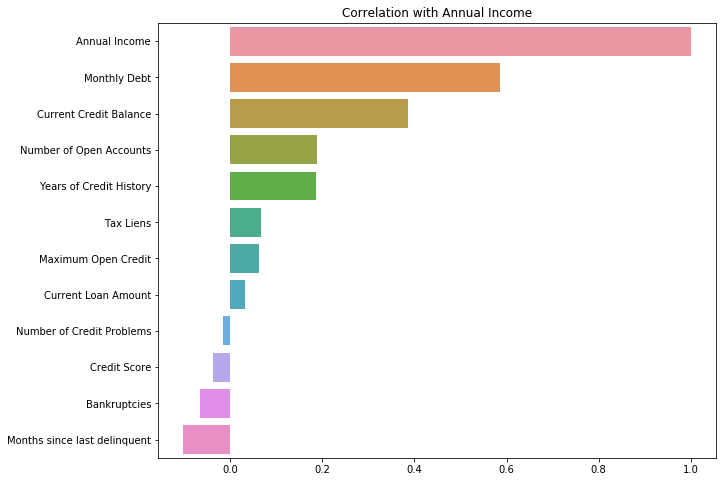

In [22]:
BASE_FEATURE_NAMES2 = df.columns.drop('Credit Default', 'Annual Income').tolist()
corr_with_target = df[BASE_FEATURE_NAMES2 + ['Annual Income']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with Annual Income')
plt.show()

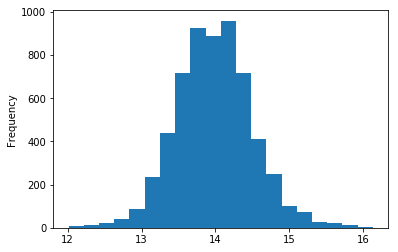

In [23]:
df['Annual Income new']= np.log(df['Annual Income'])
df['Annual Income new'].plot(kind="hist", bins=20)

**Years in current job** - считаю, что достаточно оставить в признаке число лет, будет легче вычислять

In [24]:
print((df['Years in current job']).unique())

[nan '10+ years' '8 years' '6 years' '7 years' '5 years' '1 year'
 '< 1 year' '4 years' '3 years' '2 years' '9 years']


**Tax Liens**

In [25]:
print(df['Tax Liens'].describe())
print(df['Tax Liens'].unique())
print(df['Tax Liens'].value_counts())

count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64
[0. 3. 1. 2. 4. 6. 5. 7.]
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64


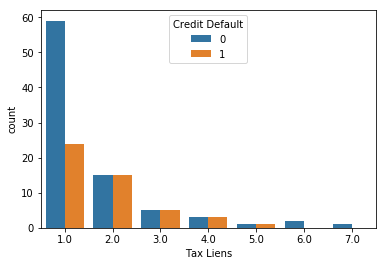

In [26]:
p = sns.countplot(data=df.loc[(df['Tax Liens'] > 0), :],
                  x = 'Tax Liens',
                  hue = 'Credit Default')

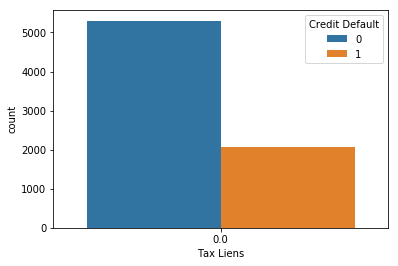

In [27]:
p = sns.countplot(data=df.loc[(df['Tax Liens'] == 0), :],
                  x = 'Tax Liens',
                  hue = 'Credit Default')


Можно заметить, что при значении до 1 включительно сильно преобладают надежные должники. 
Можно использовать это для упрощения признака. Но из-за незначительного количества значений больше 1, не буду использовать

**Months since last delinquent** 

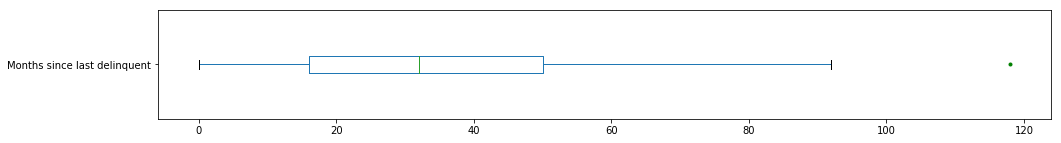

In [28]:
red_square = dict(markerfacecolor='g', markeredgecolor='g', marker='.')
df['Months since last delinquent'].plot(kind='box',  vert=False, flierprops=red_square, figsize=(16,2));

Выбросов нет, но самая проблемная колонка из-за пропусков. 
Проще выкинуть эту колонку, чем обрабатывать

**Years of Credit History**

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.800000
max        57.700000
Name: Years of Credit History, dtype: float64


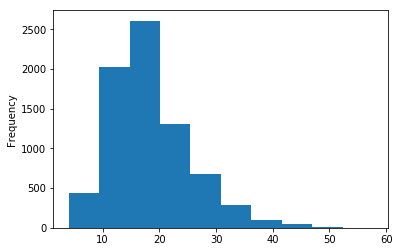

In [29]:
print((df['Years of Credit History']).describe())
df['Years of Credit History'].plot(kind="hist")

Гистограмма почти нормальная

**Maximum Open Credit**

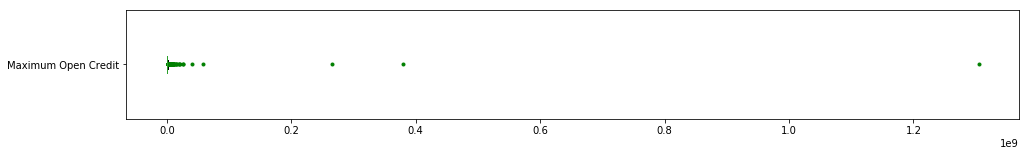

In [30]:
df['Maximum Open Credit'].plot(kind='box',  vert=False, flierprops=red_square, figsize=(16,2));

In [31]:
df.loc[(df['Maximum Open Credit'] > 3*10**7), :  ]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income new
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0,14.103884
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0,NaN
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0,14.110286
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0,14.984209
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0,15.032629


видно, что это довольно беспроблемные клиенты и доход не позволяет им выплачивать такой долг.
Предполагаю ошибку с числом нулей - вместо копеек писали рубли (или иной валюте)
    Поделю макс кредит у таких на 100 на тестовой выборке. А для обучающей выборки надежней удалить.

In [32]:
df = df.loc[df['Maximum Open Credit'] < 3*10**7]

**Number of Credit Problems**

**Number of open accounts**

count    7495.000000
mean       11.129686
std         4.910025
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64
[11. 15.  8. 13. 12.  9. 17. 10.  7.  6. 14.  3. 20. 19. 22. 18.  5. 16.
  4.  2. 23. 24. 21. 25. 32. 33. 31. 30. 29. 28. 26. 27. 43. 41. 34. 38.
 35. 37. 42.]


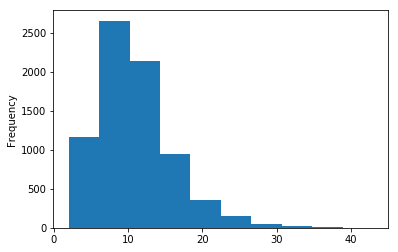

In [33]:
print(df['Number of Open Accounts'].describe())
print(df['Number of Open Accounts'].unique())
df['Number of Open Accounts'].plot(kind="hist")

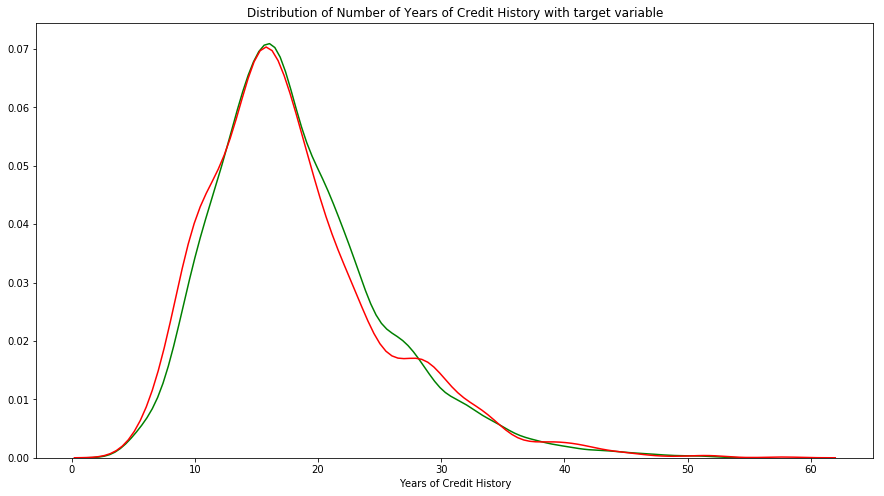

In [34]:
plt.figure(figsize=(15, 8))
x0 = df.loc[(df['Credit Default'] == 0), 'Years of Credit History']
x1 = df.loc[(df['Credit Default'] == 1), 'Years of Credit History']
ax = sns.distplot(x0, hist=False,  color = 'green')
bx = sns.distplot(x1, hist=False,  color = 'red')
plt.title('Distribution of Number of Years of Credit History with target variable')
plt.show()

интересная колонка по данным, но едва ли поможет в предсказании

**Months since last delinquent**

Очень много пропущенных значений, не буду обрабатывать

**Bankruptcies**

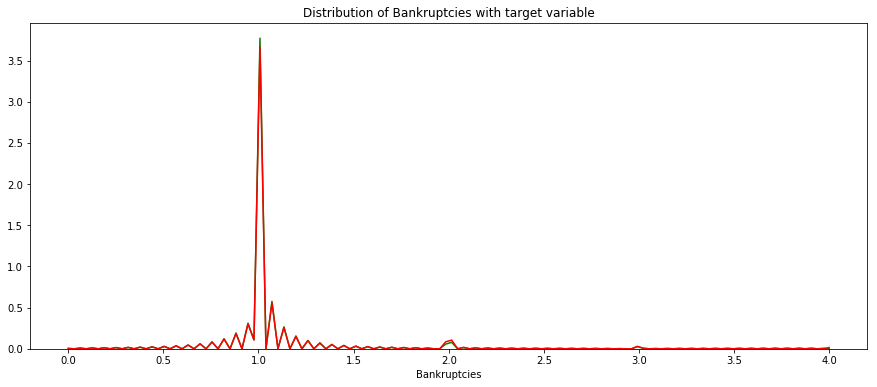

In [35]:
plt.figure(figsize=(15, 6))
x0 = df.loc[(df['Credit Default'] == 0), 'Bankruptcies']
x1 = df.loc[(df['Credit Default'] == 1), 'Bankruptcies']
ax = sns.distplot(x0, hist=False,  color = 'green')
bx = sns.distplot(x1, hist=False,  color = 'red')
plt.title('Distribution of Bankruptcies with target variable')
plt.show()
# Удивительно, но графики  идентичны так что сливаются. Едва ли признак поможет в предсказании

**Purpose**

In [36]:
print(df['Purpose'].unique())
print(df['Purpose'].value_counts(dropna=False))

['debt consolidation' 'other' 'home improvements' 'take a trip'
 'buy a car' 'small business' 'business loan' 'wedding'
 'educational expenses' 'buy house' 'medical bills' 'moving'
 'major purchase' 'vacation' 'renewable energy']
debt consolidation      5943
other                    663
home improvements        411
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               36
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64


из-за огромного преобладания одного значения не буду использовать. Да и второе с третьим местом неинтересны по своему смыслу.

**Term**

In [37]:
print(df['Term'].value_counts(dropna=False))

Short Term    5551
Long Term     1944
Name: Term, dtype: int64


Сделаю числовым признаком

**Current Loan Amount**

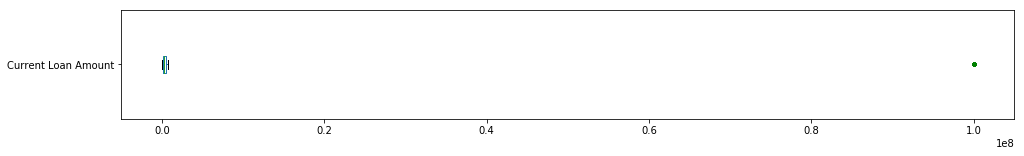

In [38]:
red_square = dict(markerfacecolor='g', markeredgecolor='g', marker='.')
df['Current Loan Amount'].plot(kind='box',  vert=False, flierprops=red_square, figsize=(16,2));

In [39]:
df.loc[(df['Current Loan Amount'] > 10**7), :  ].describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income new
count,8.690000e+02,869.000000,869.000000,869.000000,8.690000e+02,869.000000,370.000000,866.000000,869.0,8.690000e+02,869.000000,869.000000,869.0,869.000000
mean,1.425535e+06,0.024166,11.134638,18.503682,7.912383e+05,0.158803,34.664865,0.112009,99999999.0,3.010121e+05,17947.025316,730.210587,0.0,14.023339
std,8.979642e+05,0.259591,4.805820,7.026462,1.596469e+06,0.465498,21.176663,0.336825,0.0,3.551321e+05,12264.488549,21.403154,0.0,0.530573
min,2.167140e+05,0.000000,2.000000,4.800000,0.000000e+00,0.000000,0.000000,0.000000,99999999.0,0.000000e+00,0.000000,601.000000,0.0,12.286334
25%,8.664760e+05,0.000000,8.000000,13.700000,2.999700e+05,0.000000,18.000000,0.000000,99999999.0,1.145130e+05,9502.000000,726.000000,0.0,13.672190
50%,1.243778e+06,0.000000,10.000000,17.200000,5.148660e+05,0.000000,32.000000,0.000000,99999999.0,2.129900e+05,15449.000000,737.000000,0.0,14.033664
75%,1.726245e+06,0.000000,14.000000,22.200000,8.579780e+05,0.000000,49.750000,0.000000,99999999.0,3.629570e+05,23433.000000,744.000000,0.0,14.361459
max,8.758449e+06,6.000000,34.000000,50.900000,2.640700e+07,6.000000,81.000000,3.000000,99999999.0,4.249673e+06,94674.000000,751.000000,0.0,15.985529


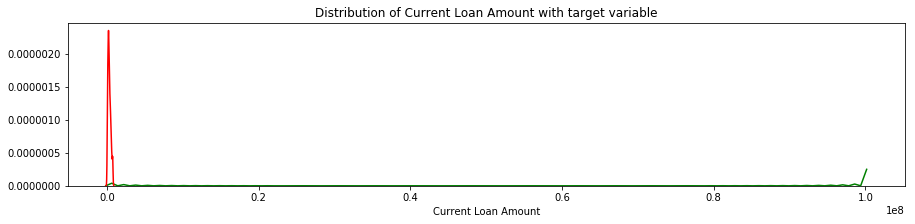

In [40]:
#Заметим, что те, у кого признак = 99999999.0, стабильно имеют целевую переменную = 0. 
#Логичней, если задолженность сделать равной  0
plt.figure(figsize=(15, 3))
x0 = df.loc[(df['Credit Default'] == 0), 'Current Loan Amount']
x1 = df.loc[(df['Credit Default'] == 1), 'Current Loan Amount']
ax = sns.distplot(x0, hist=False,  color = 'green')
bx = sns.distplot(x1, hist=False,  color = 'red')
plt.title('Distribution of Current Loan Amount with target variable')
plt.show()




**Current Credit Balance**

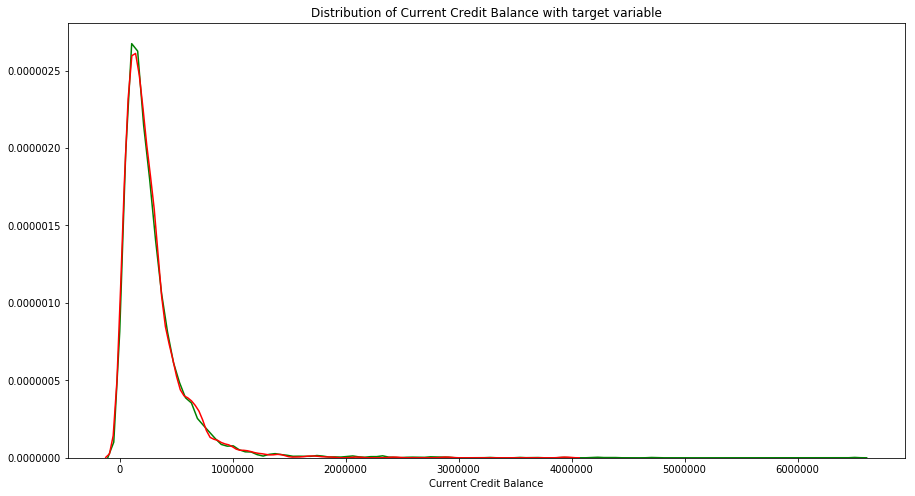

In [41]:
plt.figure(figsize=(15, 8))
x0 = df.loc[(df['Credit Default'] == 0), 'Current Credit Balance']
x1 = df.loc[(df['Credit Default'] == 1), 'Current Credit Balance']
ax = sns.distplot(x0, hist=False,  color = 'green')
bx = sns.distplot(x1, hist=False,  color = 'red')
plt.title('Distribution of Current Credit Balance with target variable')
plt.show()
# # Графики похожи

**Monthly Debt**

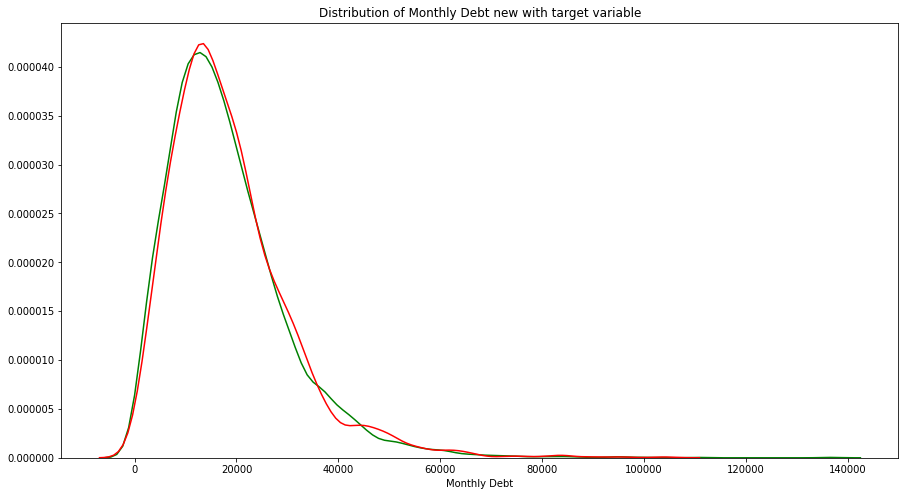

In [42]:
plt.figure(figsize=(15, 8))
x0 = df.loc[(df['Credit Default'] == 0), 'Monthly Debt']
x1 = df.loc[(df['Credit Default'] == 1), 'Monthly Debt']
ax = sns.distplot(x0, hist=False,  color = 'green')
bx = sns.distplot(x1, hist=False,  color = 'red')
plt.title('Distribution of Monthly Debt new with target variable')
plt.show()
# # Графики похожи

**Credit Score**

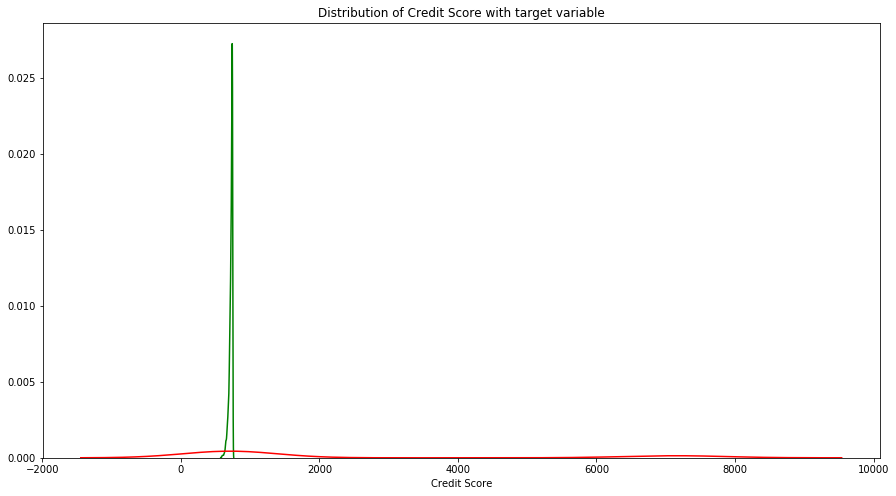

In [43]:
plt.figure(figsize=(15, 8))
x0 = df.loc[(df['Credit Default'] == 0), 'Credit Score']
x1 = df.loc[(df['Credit Default'] == 1), 'Credit Score']
ax = sns.distplot(x0, hist=False,  color = 'green')
bx = sns.distplot(x1, hist=False,  color = 'red')
plt.title('Distribution of Credit Score with target variable')
#plt.xlim(500, 1000)
plt.show()

In [44]:
print((df['Credit Score']).describe())

count    5939.000000
mean     1151.362519
std      1604.956699
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64


Много пропущенных значений. Есть много должников в районе 8000. Как будуто лишний нолик. Правда, попытка на этом сыграть привела к ухудшению прогноза.
Но из-за важности признака обработаю его особенно


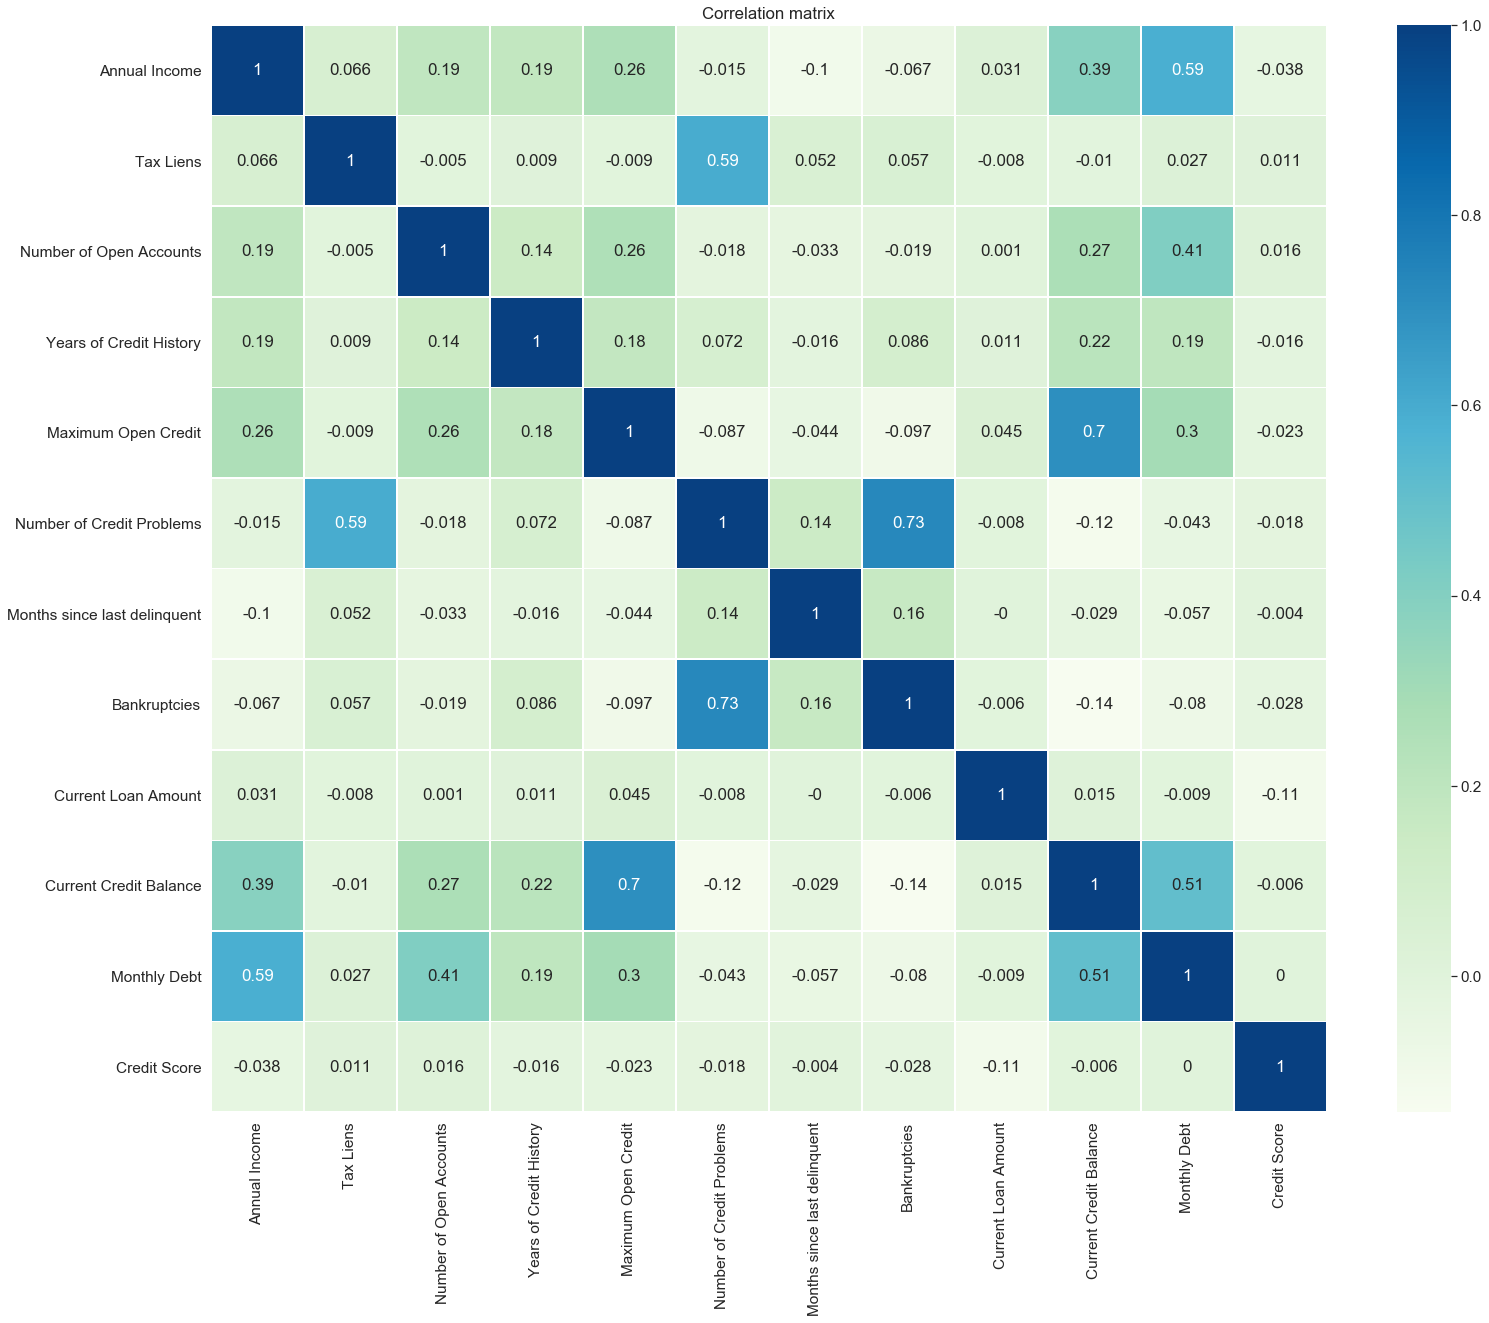

In [45]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Не вижу сильных корреляций для объединения признаков (Среди интересных признаков)

### Обработка данных <a class="anchor" id="load_data"></a>

**Home Ownership**

In [46]:
def change_Ownership(data, feature = 'Home Ownership'):
    
    data['Rent'] = 0
    data['Own_Home'] = 0
    data['Have_Mortgage'] = 0
    data['Home_Mortgage'] = 0
    #data['Years in current job new'].mask(data['Years in current job'] >9, 1, inplace=True)
    #data['Rent'].mask(data['Home Ownership'] =='Rent', 1.0, inplace=True)
    #data['Own_Home'].mask(data['Home Ownership'] =='Own Home', 1.0 inplace=True)
    #data['Have_Mortgage'].mask(data['Home Ownership'] =='Have Mortgage', 1.0, inplace=True)
    #data['Home_Mortgage'].mask(data['Home Ownership'] =='Home Mortgage', 1.0, inplace=True)
    data['Rent'].loc[(data['Home Ownership']  =='Rent')] = 1
    data['Own_Home'].loc[(data['Home Ownership']  =='Own Home')] = 1
    data['Have_Mortgage'].loc[(data['Home Ownership']  =='Have Mortgage')] = 1
    data['Home_Mortgage'].loc[(data['Home Ownership']  =='Home Mortgage')] = 1
    data['Rent'] = data['Rent'].astype('uint8')
    data['Own_Home'] = data['Own_Home'].astype('uint8')
    data['Have_Mortgage'] = data['Have_Mortgage'].astype('uint8')
    data['Home_Mortgage'] = data['Home_Mortgage'].astype('uint8')
   
    #return pd.get_dummies(data, prefix=[feature[0:3]], columns=[feature])
#df = change_Ownership(df)
change_Ownership(df)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual Income new,Rent,Own_Home,Have_Mortgage,Home_Mortgage
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,99999999.0,47386.0,7914.0,749.0,0,13.085880,0,1,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,264968.0,394972.0,18373.0,737.0,1,13.840678,0,1,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,99999999.0,308389.0,13651.0,742.0,0,13.529709,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,121396.0,95855.0,11338.0,694.0,0,13.598682,0,1,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,125840.0,93309.0,7180.0,719.0,0,13.562248,1,0,0,0


**Annual Income**

In [47]:
INCOME_R = df.loc[(df['Home Ownership'] =='Rent') , 'Annual Income'].mean()
INCOME_OH = df.loc[(df['Home Ownership'] =='Own Home') , 'Annual Income'].mean()
INCOME_HO = df.loc[(df['Home Ownership'] =='Have Mortgage') , 'Annual Income'].mean()
INCOME_HM = df.loc[(df['Home Ownership'] =='Home Mortgage') , 'Annual Income'].mean()
INCOME_MEAN = df['Annual Income'].mean()
print(INCOME_R, INCOME_OH,INCOME_HO, INCOME_HM, INCOME_MEAN)

1184131.602614897 1171777.0740740742 1058910.7142857143 1559209.4960276338 1365750.744233036


In [48]:
def change_Annual_Income(data):
    
    #data.loc[(data['Annual Income'].isnull())&(data['Home Ownership'] =='Rent'), 'Annual Income'] = INCOME_R
    #data.loc[(data['Annual Income'].isnull())&(data['Home Ownership'] =='Own Home'), 'Annual Income'] = INCOME_OH
    #data.loc[(data['Annual Income'].isnull())&(data['Home Ownership'] =='Have Mortgage'), 'Annual Income'] = INCOME_HO
    #data.loc[(data['Annual Income'].isnull())&(data['Home Ownership'] =='Home Mortgage'), 'Annual Income'] = INCOME_HM
    # На случай выброса усредню
    #data.loc[data['Annual Income']> 5*10**6, 'Annual Income'] = INCOME_MEAN
    df.loc[df['Annual Income']> 5*10**6, 'Annual Income'] = float('NaN')

**Tax Liens**

**Bankruptcies** - пропущенные значения пусть будут равными самому популярному значению -0

In [49]:
print(df['Bankruptcies'].mode())
def change_Bankruptcies(data):
    data.loc[data['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

0    0.0
dtype: float64


**Years of Credit History**

**Maximum Open Credit**

In [50]:
def change_Maximum_Credit(data):
    data.loc[data['Maximum Open Credit']> 5*10**7, 'Maximum Open Credit'] = data['Maximum Open Credit']/100

**Number of Credit Problems**

**Years in current job**

In [51]:
'''
def extract_numbers(value):
    years = re.findall('([\d]{1,2})', value)
    return str(years[0])'''
def change_Years(data):
    #Years in current job - пропущенные значения пусть будут равными среднему (Это 6 лет)
    data.loc[data['Years in current job'].isnull(), 'Years in current job'] = '6 years'
    #Перевожу в число
    data.loc[data['Years in current job']=='10+ years', 'Years in current job'] = 10
    data.loc[data['Years in current job']=='9 years', 'Years in current job'] = 9
    data.loc[data['Years in current job']=='8 years', 'Years in current job'] = 8
    data.loc[data['Years in current job']=='7 years', 'Years in current job'] = 7
    data.loc[data['Years in current job']=='6 years', 'Years in current job'] = 6
    data.loc[data['Years in current job']=='5 years', 'Years in current job'] = 5
    data.loc[data['Years in current job']=='4 years', 'Years in current job'] = 4
    data.loc[data['Years in current job']=='3 years', 'Years in current job'] = 3
    data.loc[data['Years in current job']=='2 years', 'Years in current job'] = 2
    data.loc[data['Years in current job']=='1 year', 'Years in current job'] = 1
    data.loc[data['Years in current job']=='< 1 year', 'Years in current job'] = 0
    data['Years in current job'] = data['Years in current job'].astype(float)

**Months since last delinquent**

In [52]:
def change_Month_DL(data):
    data.loc[data['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
   

**Term**

In [53]:
def change_Term(data):
    data['Term_new'] = 0
    data['Term_new'].mask(data['Term'] =='Long Term', 1, inplace=True)

**Purpose**

**Current Loan Amount**

In [54]:
def change_Loan_Amount(data):
    #data.loc[data['Current Loan Amount']==99999999.0, 'Current Loan Amount'] = 0
    pass
    

**Current Credit Balance**

In [55]:
#Преобразование чтобы распределение было нормальнее
def change_Credit_Balance(data):
    
    data['Current Credit Balance new'] = np.log(data['Current Credit Balance'])

**Monthly Debt**

In [56]:
# Преобразование чтобы распределение было нормальнее
def change_Monthly_Debt(data):
    data['Monthly Debt new'] = np.sqrt(data['Monthly Debt'])

**Credit Score**

In [57]:
#df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df['Credit Score']/10
SCORE_R = df.loc[(df['Home Ownership'] =='Rent') , 'Credit Score'].median()
SCORE_OH = df.loc[(df['Home Ownership'] =='Own Home') , 'Credit Score'].median()
SCORE_HO = df.loc[(df['Home Ownership'] =='Have Mortgage') , 'Credit Score'].median()
SCORE_HM = df.loc[(df['Home Ownership'] =='Home Mortgage') , 'Credit Score'].median()
print(SCORE_R, SCORE_OH,SCORE_HO, SCORE_HM)

730.0 730.0 704.0 733.0


In [58]:
def upgrade_base(data):
    #data = change_Ownership(data, feature ='change_Ownership')
    change_Annual_Income(data)
    change_Bankruptcies(data)
    change_Maximum_Credit(data)
    change_Term(data)
    change_Years(data)
    change_Month_DL(data)
    change_Loan_Amount(data)
    #change_Tax_Liens(data)
    change_Monthly_Debt(data)
    change_Credit_Balance(data) 
    data = change_Ownership(data)
    change_Credit_Score(data) 
    return data

In [59]:
print(df['Credit Score'].mean())
print(df['Credit Score'].median())


CREDIT_SCORE_MEDIAN = df['Credit Score'].median()
#Сделаю предположение, что значения больше 1000 - это лишний нолик.
#Почему выбрал именно median -чтобы не учитывать выброс в больших значениях(будет ниже)
#Как показано ниже, это самый важный признак поэтому обработаю его особенно
def change_Credit_Score(data):
    #data.loc[df['Credit Score'] > 1000, 'Credit Score'] = data['Credit Score']/10
    #data.loc[df['Credit Score'].isnull(), 'Credit Score'] = CREDIT_SCORE_MEDIAN
    #data.loc[(data['Credit Score'].isnull())&(df['Home Ownership'] =='Rent'), 'Credit Score'] = SCORE_R
    #data.loc[(data['Credit Score'].isnull())&(df['Home Ownership'] =='Own Home'), 'Credit Score'] = SCORE_OH
    #data.loc[(data['Credit Score'].isnull())&(df['Home Ownership'] =='Have Mortgage'), 'Credit Score'] = SCORE_HO
    #data.loc[(data['Credit Score'].isnull())&(df['Home Ownership'] =='Home Mortgage'), 'Credit Score'] = SCORE_HM
    pass

1151.362518942583
731.0


In [60]:
upgrade_base(df)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Credit Score,Credit Default,Annual Income new,Rent,Own_Home,Have_Mortgage,Home_Mortgage,Term_new,Monthly Debt new,Current Credit Balance new
0,Own Home,482087.0,6.0,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,...,749.0,0,13.085880,0,1,0,0,0,88.960665,10.766082
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,...,737.0,1,13.840678,0,1,0,0,1,135.547040,12.886570
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,...,742.0,0,13.529709,0,0,0,1,0,116.837494,12.639117
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,...,694.0,0,13.598682,0,1,0,0,0,106.480045,11.470592
4,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,...,719.0,0,13.562248,1,0,0,0,0,84.734881,11.443672


**Предсказание Annual income**

In [61]:
df['Annual Income new']= np.log(df['Annual Income'])
df_temp = copy.deepcopy(df)
#отброшу признаки, которые не важны по графику, или вместо них есть новые признаки
df_temp.pop('Tax Liens')
df_temp.pop('Credit Default')
df_temp.pop('Home Ownership')
df_temp.pop('Term')
df_temp.pop('Current Loan Amount')
df_temp.pop('Number of Credit Problems')
df_temp.pop('Bankruptcies')
df_temp.pop('Credit Score')
df_temp.pop('Months since last delinquent')
df_temp.pop('Monthly Debt')
df_temp.pop('Years in current job')
df_temp.pop('Purpose')
df_temp.pop('Annual Income')
df_temp.pop('Current Credit Balance new')



df_temp.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7495 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number of Open Accounts  7495 non-null   float64
 1   Years of Credit History  7495 non-null   float64
 2   Maximum Open Credit      7495 non-null   float64
 3   Current Credit Balance   7495 non-null   float64
 4   Annual Income new        5895 non-null   float64
 5   Rent                     7495 non-null   uint8  
 6   Own_Home                 7495 non-null   uint8  
 7   Have_Mortgage            7495 non-null   uint8  
 8   Home_Mortgage            7495 non-null   uint8  
 9   Term_new                 7495 non-null   int64  
 10  Monthly Debt new         7495 non-null   float64
dtypes: float64(6), int64(1), uint8(4)
memory usage: 497.7 KB


In [62]:
df_temp.head()

,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Current Credit Balance,Annual Income new,Rent,Own_Home,Have_Mortgage,Home_Mortgage,Term_new,Monthly Debt new
0,11.0,26.3,685960.0,47386.0,13.085880,0,1,0,0,0,88.960665
1,15.0,15.3,1181730.0,394972.0,13.840678,0,1,0,0,1,135.547040
2,11.0,35.0,1182434.0,308389.0,13.529709,0,0,0,1,0,116.837494
3,8.0,22.5,147400.0,95855.0,13.598682,0,1,0,0,0,106.480045
4,13.0,13.6,385836.0,93309.0,13.562248,1,0,0,0,0,84.734881


In [63]:
income_predict = df_temp.loc[df_temp['Annual Income new'].isnull()] 
income_predict_train = df_temp.loc[df_temp['Annual Income new'] >= 0] 
income_predict_train.describe()

,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Current Credit Balance,Annual Income new,Rent,Own_Home,Have_Mortgage,Home_Mortgage,Term_new,Monthly Debt new
count,5895.000000,5895.000000,5.895000e+03,5.895000e+03,5895.000000,5895.000000,5895.000000,5895.000000,5895.000000,5895.000000,5895.000000
mean,11.117727,18.291891,6.673276e+05,2.852843e+05,13.972552,0.425785,0.086175,0.001187,0.486853,0.266497,127.882373
std,4.898257,7.035893,9.995650e+05,3.049757e+05,0.502277,0.494503,0.280646,0.034442,0.499870,0.442165,41.466191
min,2.000000,4.000000,0.000000e+00,0.000000e+00,12.011255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,13.500000,2.771230e+05,1.140665e+05,13.642050,0.000000,0.000000,0.000000,0.000000,0.000000,100.287088
50%,10.000000,17.000000,4.734840e+05,2.093420e+05,13.968105,0.000000,0.000000,0.000000,0.000000,0.000000,126.479247
75%,14.000000,21.800000,7.862470e+05,3.572095e+05,14.302551,1.000000,0.000000,0.000000,1.000000,1.000000,153.723778
max,43.000000,57.700000,2.640700e+07,6.506797e+06,15.405975,1.000000,1.000000,1.000000,1.000000,1.000000,322.546121


In [64]:
income_predictions = rforest_prediction(income_predict_train, income_predict, 'Annual Income new')
df.loc[df_temp['Annual Income new'].isnull(), 'Annual Income new'] = income_predictions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s


r2 на учебной выборке: 0.9101927545919074
Прогнозирую Annual Income new
(1600, 10)


[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished


**Credit Score**- самый важный признак, поэтому сделаю предсказание, а не просто усреднение

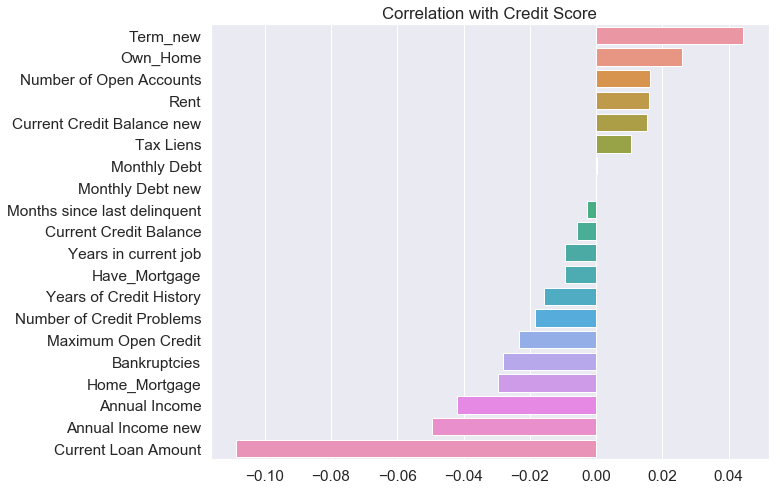

In [65]:
BASE_FEATURE_NAMES3 = df.columns.drop(['Credit Score', 'Credit Default']).tolist()
corr_with_target = df[BASE_FEATURE_NAMES3 + ['Credit Score']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with Credit Score')
plt.show()

In [66]:
df_temp = copy.deepcopy(df)
#отброшу признаки, которые не важны по графику, или вместо них есть новые признаки
#df_temp.pop('Tax Liens')
df_temp.pop('Credit Default')
df_temp.pop('Home Ownership')
df_temp.pop('Term')
df_temp.pop('Number of Credit Problems')
df_temp.pop('Months since last delinquent')
df_temp.pop('Monthly Debt')
df_temp.pop('Years in current job')
df_temp.pop('Purpose')
df_temp.pop('Annual Income')
df_temp.pop('Current Credit Balance new')

df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7495 entries, 0 to 7499
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Tax Liens                7495 non-null   float64
 1   Number of Open Accounts  7495 non-null   float64
 2   Years of Credit History  7495 non-null   float64
 3   Maximum Open Credit      7495 non-null   float64
 4   Bankruptcies             7495 non-null   float64
 5   Current Loan Amount      7495 non-null   float64
 6   Current Credit Balance   7495 non-null   float64
 7   Credit Score             5939 non-null   float64
 8   Annual Income new        7495 non-null   float64
 9   Rent                     7495 non-null   uint8  
 10  Own_Home                 7495 non-null   uint8  
 11  Have_Mortgage            7495 non-null   uint8  
 12  Home_Mortgage            7495 non-null   uint8  
 13  Term_new                 7495 non-null   int64  
 14  Monthly Debt new        

**Предсказание Credit Score**

In [67]:
score_predict = df_temp.loc[df_temp['Credit Score'].isnull()] 
score_predict_train = df_temp.loc[df_temp['Credit Score'] >= 0] 
score_predict_train.describe()

,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Bankruptcies,Current Loan Amount,Current Credit Balance,Credit Score,Annual Income new,Rent,Own_Home,Have_Mortgage,Home_Mortgage,Term_new,Monthly Debt new
count,5939.000000,5939.000000,5939.000000,5.939000e+03,5939.000000,5.939000e+03,5.939000e+03,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000
mean,0.029298,11.124263,18.309530,6.779063e+05,0.117865,1.489819e+07,2.901177e+05,1151.362519,13.977037,0.424987,0.086378,0.001179,0.487456,0.266206,128.434847
std,0.269382,4.903348,7.041812,1.035916e+06,0.351941,3.523598e+07,3.198479e+05,1604.956699,0.504716,0.494383,0.280945,0.034314,0.499885,0.442011,42.237883
min,0.000000,2.000000,4.000000,0.000000e+00,0.000000,1.124200e+04,0.000000e+00,585.000000,12.011255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,13.500000,2.778930e+05,0.000000,1.889250e+05,1.143610e+05,711.000000,13.645625,0.000000,0.000000,0.000000,0.000000,0.000000,100.351880
50%,0.000000,10.000000,17.000000,4.761680e+05,0.000000,3.238620e+05,2.100640e+05,731.000000,13.970434,0.000000,0.000000,0.000000,0.000000,0.000000,126.799054
75%,0.000000,14.000000,21.800000,7.929020e+05,0.000000,5.465020e+05,3.604870e+05,743.000000,14.306693,1.000000,0.000000,0.000000,1.000000,1.000000,154.248176
max,7.000000,43.000000,57.700000,2.640700e+07,4.000000,1.000000e+08,6.506797e+06,7510.000000,15.405975,1.000000,1.000000,1.000000,1.000000,1.000000,369.701231


In [68]:
score_predictions = rforest_prediction(score_predict_train, score_predict, 'Credit Score')
df.loc[df_temp['Credit Score'].isnull(), 'Credit Score'] = score_predictions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s


r2 на учебной выборке: 0.7614085352114826
Прогнозирую Credit Score
(1556, 14)


[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished


### Предсказание

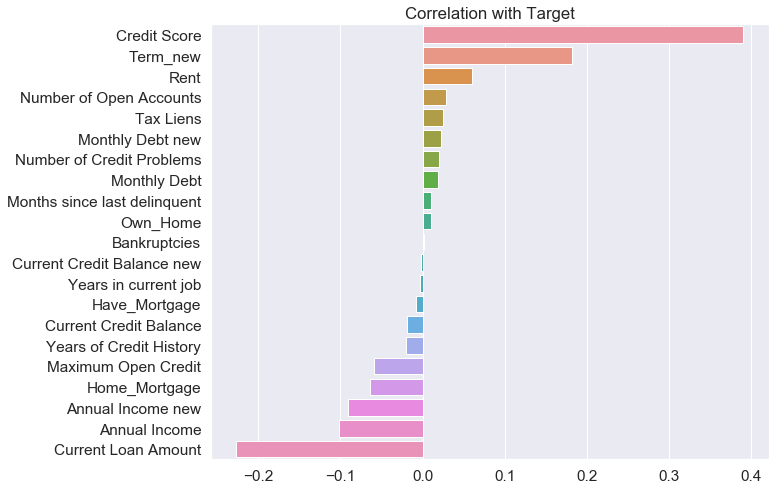

In [69]:
BASE_FEATURE_NAMES = df.columns.drop(['Credit Default']).tolist()
corr_with_target = df[BASE_FEATURE_NAMES + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with Target')
plt.show()

In [70]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

NUM_FEATURE_NAMES_NEW = ['Annual Income', 'Years in current job', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems',  'Term_new',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt new', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']
NEW_FEATURE_NAMES =['Tax Liens new', 'Monthly Debt new', 'Rent', 'Years in current job']
SELECTED_FEATURE_NAMES_FINAL = ['Annual Income new', 'Years in current job', 'Rent', 
                                'Maximum Open Credit', 'Current Loan Amount', 'Have_Mortgage',
                                'Current Credit Balance', 
                                'Monthly Debt new', 'Credit Score', 'Term_new']

In [71]:
df_train = copy.deepcopy(df)

**Нормализация данных**

In [72]:
scaler = StandardScaler()
df_norm = copy.deepcopy(df_train)
#df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df_norm[SELECTED_FEATURE_NAMES_FINAL] = scaler.fit_transform(df_norm[SELECTED_FEATURE_NAMES_FINAL])

df_norm_copy = df_norm.copy()

In [73]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7495 entries, 0 to 7499
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7495 non-null   object 
 1   Annual Income                 5895 non-null   float64
 2   Years in current job          7495 non-null   float64
 3   Tax Liens                     7495 non-null   float64
 4   Number of Open Accounts       7495 non-null   float64
 5   Years of Credit History       7495 non-null   float64
 6   Maximum Open Credit           7495 non-null   float64
 7   Number of Credit Problems     7495 non-null   float64
 8   Months since last delinquent  7495 non-null   float64
 9   Bankruptcies                  7495 non-null   float64
 10  Purpose                       7495 non-null   object 
 11  Term                          7495 non-null   object 
 12  Current Loan Amount           7495 non-null   float64
 13  Cur

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [75]:
X = df_norm_copy [SELECTED_FEATURE_NAMES_FINAL]
y = df_norm_copy [TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [76]:

df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
 
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2950
Name: Credit Default, dtype: int64

In [77]:
X_train = df_balanced.drop(columns=TARGET_NAME)
#X_train = df_balanced.drop(columns=FEATURES_TO_DROP)
y_train = df_balanced[TARGET_NAME]

In [78]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 1], silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)


TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3771
           1       0.93      0.84      0.88      2950

   micro avg       0.90      0.90      0.90      6721
   macro avg       0.90      0.89      0.90      6721
weighted avg       0.90      0.90      0.90      6721

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1611
           1       0.55      0.48      0.51       638

   micro avg       0.74      0.74      0.74      2249
   macro avg       0.68      0.66      0.67      2249
weighted avg       0.73      0.74      0.73      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1362  249
1                334  304


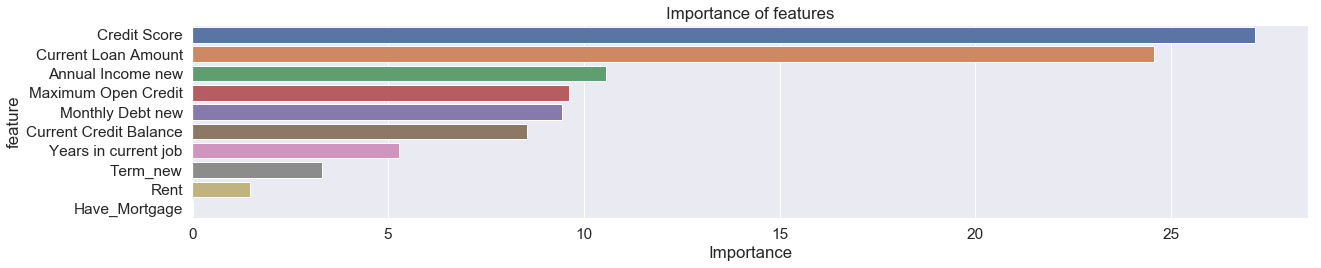

In [79]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

**Снижение переобучения**

In [80]:
final_model = catb.CatBoostClassifier(class_weights = [1, 1], l2_leaf_reg=200, 
                                      silent=True, random_state=21 )
'''
final_model = catb.CatBoostClassifier(class_weights = [1, 3], n_estimators=700, max_depth=12,
                                      l2_leaf_reg=10,learning_rate= 0.07,
                                      silent=True, random_state=21)'''
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      3771
           1       0.82      0.67      0.74      2950

   micro avg       0.79      0.79      0.79      6721
   macro avg       0.80      0.78      0.78      6721
weighted avg       0.80      0.79      0.79      6721

TEST

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1611
           1       0.55      0.53      0.54       638

   micro avg       0.74      0.74      0.74      2249
   macro avg       0.68      0.68      0.68      2249
weighted avg       0.74      0.74      0.74      2249

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1340  271
1                303  335


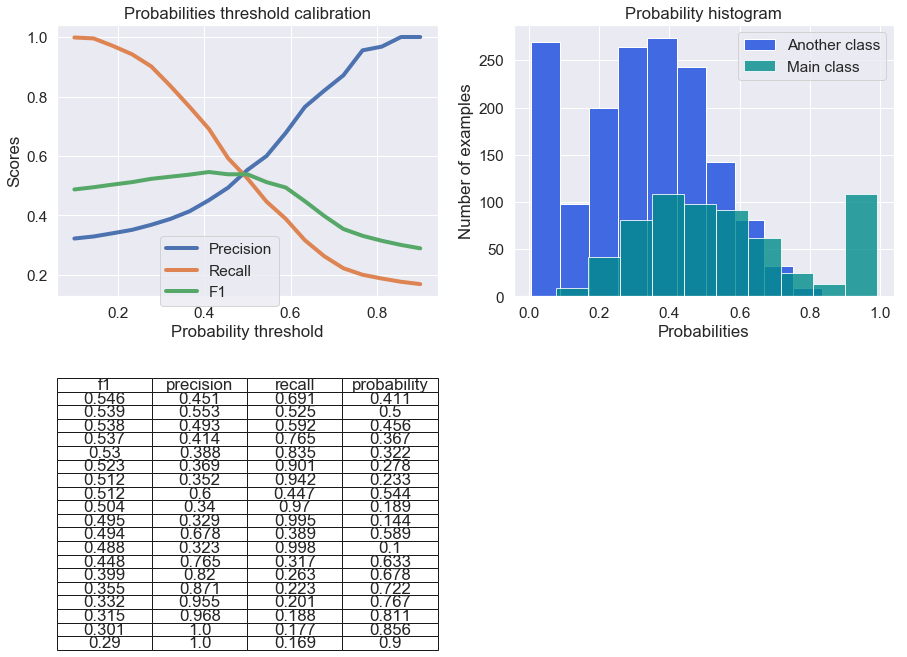

In [81]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [82]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Прогнозирование для тестовой выборки

In [83]:
df_test=pd.read_csv(TEST_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [84]:
df_test_copy = copy.deepcopy(df_test)
# df_test_processed = preprocess_data(df_test_processed)
df_test_copy.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [85]:
upgrade_base(df_test_copy)
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2500 non-null   float64
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

**Предсказание Annual income**

In [86]:
df_test_copy['Annual Income new'] = np.log(df_test_copy['Annual Income'])
df_temp = copy.deepcopy(df_test_copy)
df_temp.pop('Tax Liens')
df_temp.pop('Home Ownership')
df_temp.pop('Term')
df_temp.pop('Current Loan Amount')
df_temp.pop('Number of Credit Problems')
df_temp.pop('Bankruptcies')
df_temp.pop('Credit Score')
df_temp.pop('Months since last delinquent')
df_temp.pop('Monthly Debt')
df_temp.pop('Years in current job')
df_temp.pop('Purpose')
df_temp.pop('Annual Income')
df_temp.pop('Current Credit Balance new')
df_temp.info()
#отделяю значения которые надо прогнозировать
income_predict = df_temp.loc[df_temp['Annual Income new'].isnull()] 
income_predictions = rforest_prediction(income_predict_train, income_predict, 'Annual Income new')
print(income_predictions)
df_test_copy.loc[df_temp['Annual Income new'].isnull(), 'Annual Income new'] = income_predictions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number of Open Accounts  2500 non-null   float64
 1   Years of Credit History  2500 non-null   float64
 2   Maximum Open Credit      2500 non-null   float64
 3   Current Credit Balance   2500 non-null   float64
 4   Term_new                 2500 non-null   int64  
 5   Monthly Debt new         2500 non-null   float64
 6   Rent                     2500 non-null   uint8  
 7   Own_Home                 2500 non-null   uint8  
 8   Have_Mortgage            2500 non-null   uint8  
 9   Home_Mortgage            2500 non-null   uint8  
 10  Annual Income new        1987 non-null   float64
dtypes: float64(6), int64(1), uint8(4)
memory usage: 146.6 KB


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finis

r2 на учебной выборке: 0.9101927545919074
Прогнозирую Annual Income new
(513, 10)
[13.3223021  13.57967145 13.52003467 13.32454979 13.67007824 13.29406705
 13.65668681 13.37557471 13.58110613 13.36782622 13.67261735 13.73020925
 13.41722754 13.74541839 13.59872009 13.58470641 13.74022935 13.40134119
 13.61877898 13.84161686 13.39443109 13.44302749 13.60745776 13.66775982
 13.43979625 13.52611794 13.40655329 13.44983735 13.29846767 13.48236563
 13.77628943 13.446073   13.2971469  12.99333199 13.72827283 13.25925352
 13.51248742 13.33884871 13.8070435  13.39041157 13.53755025 13.47841035
 13.90257618 13.33837299 13.22788675 13.18124428 13.32565861 13.68835279
 13.28283322 13.32804292 13.79738313 13.27317712 13.38495238 13.74847922
 13.2400272  13.35160511 13.68954088 13.54824121 13.96717966 13.45466696
 13.57246029 13.5450143  13.19737448 13.49552661 13.3104774  13.54134906
 13.59888843 13.63897574 13.37654666 13.27069562 13.57879345 13.46031059
 13.34787793 13.73581121 13.25937789 13.55

**Предсказание Credit Score**

In [87]:
df_temp = copy.deepcopy(df_test_copy)
df_temp.pop('Home Ownership')
df_temp.pop('Term')
df_temp.pop('Number of Credit Problems')
df_temp.pop('Months since last delinquent')
df_temp.pop('Monthly Debt')
df_temp.pop('Years in current job')
df_temp.pop('Purpose')
df_temp.pop('Annual Income')
df_temp.pop('Current Credit Balance new')
score_predict = df_temp.loc[df_temp['Credit Score'].isnull()] 
score_predictions = rforest_prediction(score_predict_train, score_predict, 'Credit Score')
print(score_predictions)
df_test_copy.loc[df_temp['Credit Score'].isnull(), 'Credit Score'] = score_predictions

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished


r2 на учебной выборке: 0.7614085352114826
Прогнозирую Credit Score
(513, 14)
[2006.63425379 2620.74745395 4154.39653043 3438.361302   4414.84439881
 2492.75665403 3232.16004785 2529.41606049 3034.21633198 3634.21814516
 2651.06647769 3216.04318256 3608.66329118 3237.42122119 3409.24672371
 2904.72103577 3203.70462201 2495.11199242 2422.5573115  1785.49481391
 3446.95108967 2172.56981699 3335.21603945 3108.10898281 3494.53485592
 3979.69625146 3084.06090681 3501.82708695 3481.62725595 2905.23986749
 3631.67684744 3153.49556454 2896.97857685 4220.95431333 3476.97730961
 1840.64258363 3085.34205829 3216.66826097 3840.09412176 2905.92370967
 2914.85536811 2539.20255977 4194.04019305 3272.15786436 1951.42233643
 1772.27731231 4229.60856071 3392.59574545 3997.25370833 2242.89576843
 2979.95381169 1872.33345463 3399.30811313 3511.07057615 3288.65646662
 2672.63277239 2861.06949054 3294.09790469 4092.87342561 2894.10368358
 3572.09488388 4024.75925509 2274.99351132 2941.56729099 3239.53583942


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished


**Нормализация данных**

In [88]:
#df_test_copy[NUM_FEATURE_NAMES] = scaler.fit_transform(df_test_copy[NUM_FEATURE_NAMES])
df_test_norm = copy.deepcopy(df_test_copy)
df_test_norm[SELECTED_FEATURE_NAMES_FINAL] = scaler.fit_transform(df_test_norm[SELECTED_FEATURE_NAMES_FINAL])

#df_norm_copy = df_norm.copy()

In [89]:
Xt = df_test_norm[SELECTED_FEATURE_NAMES_FINAL]
#df_test_processed.pop('Pur_wedding')
Xt.head(5)

,Annual Income new,Years in current job,Rent,Maximum Open Credit,Current Loan Amount,Have_Mortgage,Current Credit Balance,Monthly Debt new,Credit Score,Term_new
0,-1.076738,-0.546248,1.204566,-0.440658,-0.371832,-0.052989,-0.503642,-1.074821,0.227938,-0.585973
1,-2.943931,-1.385940,1.204566,-0.596030,-0.374441,-0.052989,-0.661931,-1.882829,-0.523018,-0.585973
2,0.147823,-0.826145,-0.830174,-0.456069,-0.370663,-0.052989,-0.396341,0.201093,3.244870,-0.585973
3,0.257981,1.133137,-0.830174,-0.219085,-0.370129,-0.052989,-0.219968,0.885999,-0.500046,-0.585973
4,1.513916,0.013547,-0.830174,0.487970,-0.352759,-0.052989,0.341051,1.835087,-0.518998,1.706565


In [90]:
y_test_pred = final_model.predict(Xt)

In [91]:
prediction = pd.DataFrame(data=y_test_pred)

In [92]:
prediction.to_csv(PREDICTION_PATH, index=False, encoding='utf-8')